
# Fringe Extraction on Uneven Illumination — Interactive Notebook

This notebook provides Shading correction → CLAHE → Local threshold (Sauvola) for images with uneven illumination (like interferometry fringes):

> The notebook expects your image at `ReferenceCropped.png`. You can replace that path with your own.


In [2]:

# If running locally, ensure these are installed:
# !pip install opencv-python-headless scikit-image ipywidgets matplotlib numpy

import os, math, numpy as np, cv2
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets

from skimage import img_as_ubyte
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_sauvola
from skimage.filters.rank import otsu
from skimage.morphology import disk, opening

plt.rcParams['figure.dpi'] = 130

# Convenience: safe imread
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image at: {path}")
    return img


Loaded image ShotCropped.png  shape=(650, 1231), dtype=uint8


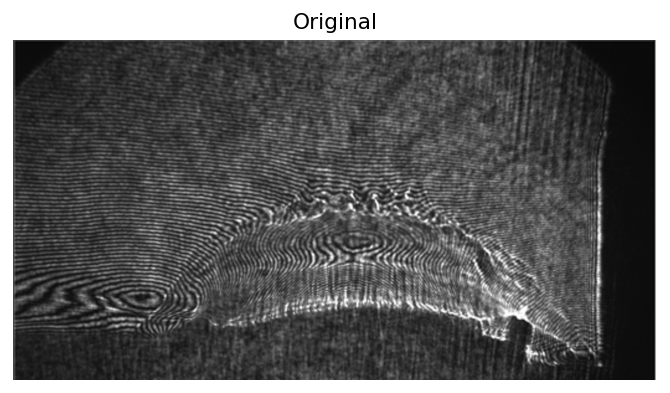

In [3]:

# --- Load your image here ---
IMG_PATH = "ShotCropped.png"  # change if needed
img = read_gray(IMG_PATH)
h, w = img.shape[:2]
print(f"Loaded image {IMG_PATH}  shape={img.shape}, dtype={img.dtype}")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original')
plt.show()


In [4]:

def show_triptych(a, b, c, titles=('Stage 1','Stage 2','Stage 3'), cmap='gray'):
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    for ax, im, t in zip(axs, [a, b, c], titles):
        ax.imshow(im, cmap=cmap)
        ax.set_title(t)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:

def pipeline_shading_sauvola(img, sigma=35.0, clip=2.5, tile=8, win=31, k=0.20, post_open=1):
    # Background via large Gaussian blur
    bg = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=sigma, sigmaY=sigma)
    flat = cv2.divide(img, bg, scale=255)
    # CLAHE
    tile = max(2, int(tile))
    clahe = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=(tile, tile))
    enh = clahe.apply(flat)
    # Sauvola
    win = int(win) if int(win)%2==1 else int(win)+1
    thv = threshold_sauvola(enh, window_size=win, k=float(k))
    binary = (enh > thv).astype(np.uint8) * 255
    if post_open > 0:
        ksz = int(post_open)
        ksz = max(1, ksz)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((ksz,ksz), np.uint8))
    return flat, enh, binary

def ui_shading_sauvola(img):
    ui = widgets.interactive(
        lambda sigma, clip, tile, win, k, post_open: show_triptych(
            *pipeline_shading_sauvola(img, sigma=sigma, clip=clip, tile=tile, win=win, k=k, post_open=post_open),
            titles=('Illumination-flattened', 'CLAHE', 'Sauvola binary')
        ),
        sigma=widgets.FloatSlider(value=35.0, min=5.0, max=80.0, step=1.0, description='Blur sigma'),
        clip=widgets.FloatSlider(value=2.5, min=1.0, max=8.0, step=0.1, description='CLAHE clip'),
        tile=widgets.IntSlider(value=8, min=4, max=32, step=1, description='CLAHE tile'),
        win=widgets.IntSlider(value=31, min=9, max=101, step=2, description='Sauvola win'),
        k=widgets.FloatSlider(value=0.20, min=0.05, max=0.40, step=0.01, description='Sauvola k'),
        post_open=widgets.IntSlider(value=1, min=0, max=5, step=1, description='Post open')
    )
    display(ui)

ui_shading_sauvola(img)
flat, enh, binary = pipeline_shading_sauvola(img, sigma=5.0, clip=8, tile=4, win=9, k=0.05, post_open=0)
cv2.imwrite("binary.png", binary)

interactive(children=(FloatSlider(value=35.0, description='Blur sigma', max=80.0, min=5.0, step=1.0), FloatSli…

True